In [1]:
import pandas as pd
import sqlite3

#Loading csv
df = pd.read_csv('../data/netflix.csv')

#Creates connection to SQLite database
conn = sqlite3.connect('kdot_netflix_data.db')

#Exports Dataframe to the database
df.to_sql('kdot_netflix_data', conn, if_exists='replace', index=False)

#Closes connection
# conn.close()


8807

In [2]:
#Preview the schema
pd.read_sql_query("PRAGMA table_info(kdot_netflix_data);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,show_id,TEXT,0,None,0
1,1,type,TEXT,0,None,0
2,2,title,TEXT,0,None,0
3,3,director,TEXT,0,None,0
4,4,cast,TEXT,0,None,0
5,5,country,TEXT,0,None,0
6,6,date_added,TEXT,0,None,0
7,7,release_year,INTEGER,0,None,0
8,8,rating,TEXT,0,None,0
9,9,duration,TEXT,0,None,0


In [3]:
#Counts the total records
pd.read_sql_query("SELECT COUNT(*) AS total_records FROM kdot_netflix_data;", conn)

,total_records
0,8807


In [4]:
#A look at the first five titles
pd.read_sql_query("""
                SELECT title, type, release_year
                FROM kdot_netflix_data
                LIMIT 5;
""", conn)

,title,type,release_year
0,Dick Johnson Is Dead,Movie,2020
1,Blood & Water,TV Show,2021
2,Ganglands,TV Show,2021
3,Jailbirds New Orleans,TV Show,2021
4,Kota Factory,TV Show,2021


In [5]:
#Count of movies bs tv shows
pd.read_sql_query("""
    SELECT type, COUNT(*) AS total
    FROM kdot_netflix_data
    GROUP BY type;
""", conn)

,type,total
0,Movie,6131
1,TV Show,2676


In [6]:
#Top 10 genres
pd.read_sql_query("""
    SELECT listed_in, COUNT(*) AS genre_count
    FROM kdot_netflix_data
    GROUP BY listed_in
    ORDER BY genre_count DESC
    LIMIT 10;
""", conn)

,listed_in,genre_count
0,"Dramas, International Movies",362
1,Documentaries,359
2,Stand-Up Comedy,334
3,"Comedies, Dramas, International Movies",274
4,"Dramas, Independent Movies, International Movies",252
5,Kids' TV,220
6,Children & Family Movies,215
7,"Children & Family Movies, Comedies",201
8,"Documentaries, International Movies",186
9,"Dramas, International Movies, Romantic Movies",180


### The genres data is not flatten so need to split and flatten data for more accurte showing

In [7]:
#Split and explode data
df_genres = df[['listed_in']].dropna()
df_genres['genre'] = df_genres['listed_in'].str.split(',')
df_genres = df_genres.explode('genre')

#Trimming the whitespace
df_genres['genre'] = df_genres['genre'].str.strip()

#Counting
genre_counts = df_genres['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

#New counting of top 10
genre_counts.head(10)

,genre,count
0,International Movies,2752
1,Dramas,2427
2,Comedies,1674
3,International TV Shows,1351
4,Documentaries,869
5,Action & Adventure,859
6,TV Dramas,763
7,Independent Movies,756
8,Children & Family Movies,641
9,Romantic Movies,616


### 🎬 Top Genres Breakdown (Normalized)

Initially, the dataset stored all genres in a single string, separated by commas (e.g., `"Dramas, International Movies"`). Counting these strings resulted in inaccurate genre distributions since combined categories were treated as unique.

To resolve this, I used `str.split()` and `explode()` to normalize the genres into individual rows. This allowed me to correctly calculate how often each distinct genre appears across the entire dataset.

The bar chart below highlights the **Top 10 genres** after this transformation, providing a much clearer view into the types of content available on Netflix.


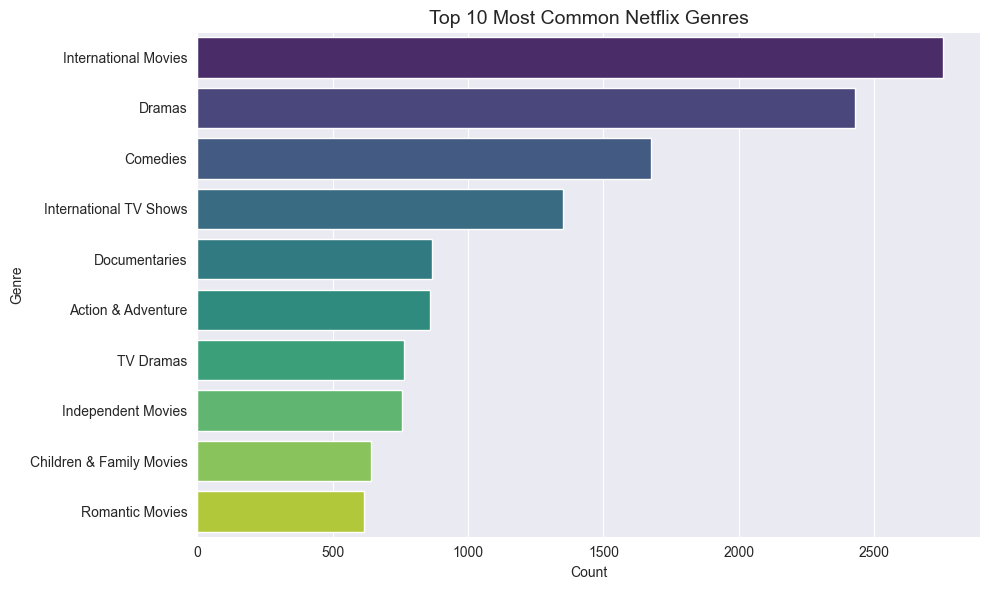

In [8]:
#Importing tools for visuals
import seaborn as sns
import matplotlib.pyplot as plt

#Setting plot style
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts.head(10), y='genre', x='count',hue='genre', palette='viridis')

#Adding labels and title
plt.title('Top 10 Most Common Netflix Genres', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig('../images/kdot_netflix_genres.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
#Saves Genre table to SQLite
genre_counts.to_sql('normalized_genre_counts', conn, if_exists='replace', index=False)

42